In [1]:
from sklearn.datasets import load_digits #import the dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
digits = load_digits()
X = digits.data
y = digits.target

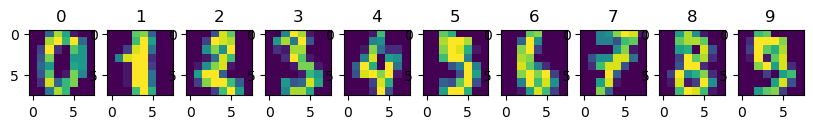

In [3]:
_, axes = plt.subplots(1, 10, figsize=(10,5))
for ax, image, label in zip(axes, X, y):
    ax.imshow(image.reshape(8, 8))
    ax.set_title('%i' % label)


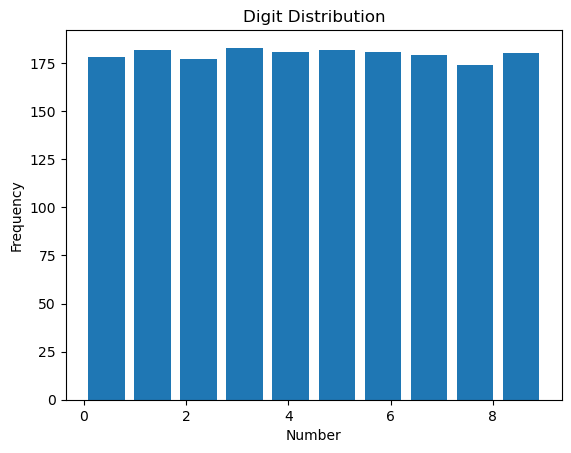

In [4]:
plt.hist(y,rwidth=0.8)
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Digit Distribution')
plt.show()

# Scaling and train-test split

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# One hot encoding

In [7]:
def one_hot_encoding(y):
    unique_vals = np.unique(y)
    hot_y = np.zeros((len(y),len(unique_vals)))
    for i in range(len(hot_y)):
        hot_y[i, int(y[i])] = 1
    return hot_y

hot_y = one_hot_encoding(y)
print(hot_y[144],y[144])  
hot_y

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 4


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

# Activation functions

In [8]:
def f_x_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def df_x_sigmoid(x):
    return f_x_sigmoid(x)*(1-f_x_sigmoid(x))

def f_x_relu(x):
    return np.maximum(0, x)

def df_x_relu(x):
    return np.where(x <= 0, 0, 1)

def f_tanh(x):
    return np.tanh(x)

def df_tanh(x):
    return 1-(f_tanh(x))**2

def d(activation_function, x):
    if activation_function == "sigmoid":
        return df_x_sigmoid(x)
    if activation_function == "relu":
        return np.where(x <= 0, 0, 1)
    if activation_function == "tanh":
        return 1-(f_tanh(x))**2
    

# Initialize weights and biases

In [9]:
def initialize_network(input_layer_size = 64, hidden_layer_size = 30, output_layer_size = 10):
    network = {
        'W1': np.random.randn(input_layer_size, hidden_layer_size) * 0.01,  # Weights for layer 1
        'b1': np.zeros(hidden_layer_size),                                 # Biases for layer 1
        'W2': np.random.randn(hidden_layer_size, output_layer_size) * 0.01, # Weights for layer 2
        'b2': np.zeros(output_layer_size)                                  # Biases for layer 2
    }
    return network

# Feedforward function: Sigmoid

In [10]:
# Feedforward function
def feedforward(x, w1, b1, w2, b2, activation='relu'):
    activation_func = f_x_relu if activation == 'relu' else f_tanh if activation == 'tanh' else f_x_sigmoid
    z1 = x @ w1 + b1
    A1 = activation_func(z1)
    z2 = A1 @ w2 + b2
    A2 = activation_func(z2)
    return z1, A1, z2, A2

# Mean squared error
def mse(y_true, A2):
    return np.mean(np.square(y_true - y_pred))


# Back propagation

In [19]:

# Gradients
def dw2(A1, A2, hot_y, z2, activation):
    dE_dYh = 2 * (A2 - hot_y)
    dYh_dz2 = d(activation, z2)
    dz2_dw2 = A1.T

    return dz2_dw2 @ (dE_dYh * dYh_dz2)


def db2(A2, hot_y, z2, activation):
    dE_dYh = 2 * (A2 - hot_y)
    dYh_dz2 = d(activation, z2)
    
    return np.sum(dE_dYh * dYh_dz2, axis=0)

def dw1(A2, hot_y, z2, w2, z1, X, activation):
    dE_dYh = 2 * (A2 - hot_y)
    dYh_dz2 = d(activation, z2)
    dz2_dA1 = w2.T
    dA1_dz1 = d(activation, z1)
    dz1_dw1 = X.T
    
    return dz1_dw1 @ (((dE_dYh * dYh_dz2) @ dz2_dA1) * dA1_dz1)


def db1(A2,hot_y,z1,z2,w2, activation):
    dE_dYh = 2*(A2-hot_y)
    dYh_dz2 = d(activation,z2)
    dz2_dA1 = w2.T
    dA1_dz1 = d(activation,z1)
    
    return (np.sum(((dE_dYh * dYh_dz2) @ dz2_dA1) * dA1_dz1, axis=0))

    
def backpropagation(X, hot_y, network, activation_name='relu', lr=0.0001):
    w1, b1, w2, b2 = network['W1'], network['b1'], network['W2'], network['b2']
    z1, A1, z2, A2 = feedforward(X, w1, b1, w2, b2, activation=activation_name)

    # Gradient calculations
    grad_w2 = dw2(A1, A2, hot_y, z2, activation=activation_name) / X.shape[0]
    grad_b2 = db2(A2, hot_y, z2, activation=activation_name) / X.shape[0]
    grad_w1 = dw1(A2, hot_y, z2, w2, z1, X, activation=activation_name) / X.shape[0]
    grad_b1 = db1(A2, hot_y, z1, z2, w2, activation=activation_name) / X.shape[0]

    # Update weights and biases
    network['W2'] -= lr * grad_w2
    network['b2'] -= lr * grad_b2
    network['W1'] -= lr * grad_w1
    network['b1'] -= lr * grad_b1

    # Calculate MSE
    y_pred = np.argmax(A2, axis=1)
    mse_loss = np.mean((np.argmax(hot_y, axis=1) - y_pred) ** 2)
    
    return network, mse_loss

# Train, predict, accuracy

In [12]:
def train_network(X_train, y_train, network, activation_name='relu', lr=0.0001, epochs=1000):
    hot_y_train = one_hot_encoding(y_train)
    loss_values = []

    for epoch in range(epochs):
        network, mse_loss = backpropagation(X_train, hot_y_train, network, activation_name, lr)
        loss_values.append(mse_loss)

    return network, loss_values

def predict(X, network):
    w1, b1, w2, b2 = network['W1'], network['b1'], network['W2'], network['b2']
    _, _, _, A2 = feedforward(X, w1, b1, w2, b2, activation='relu')
    predictions = np.argmax(A2, axis=1)
    return predictions

def accuracy(X, y, network):
    hot_y = one_hot_encoding(y)
    predictions = predict(X, network)
    correct_predictions = np.sum(predictions == np.argmax(hot_y, axis=1))
    acc = correct_predictions / len(y)
    return acc


# Experimenting and reporting

Learning Rate: 0.001
Training Accuracy: 60.06%
Test Accuracy: 59.26%
-----------------------------------
Learning Rate: 0.01
Training Accuracy: 95.47%
Test Accuracy: 93.70%
-----------------------------------
Learning Rate: 0.1
Training Accuracy: 99.68%
Test Accuracy: 98.33%
-----------------------------------


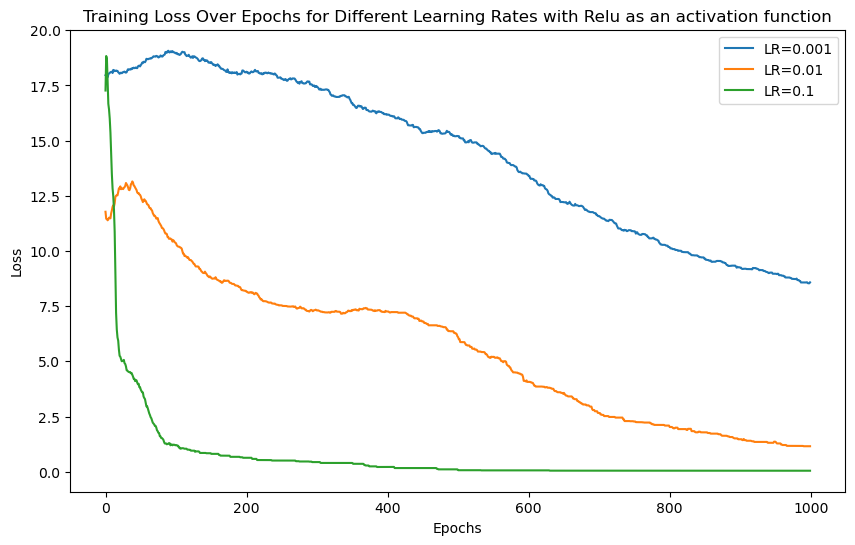

In [13]:
learning_rates = [0.001, 0.01, 0.1]
plt.figure(figsize=(10, 6))

for lr in learning_rates:
    network = initialize_network()
    trained_network, loss_values = train_network(X_train, y_train, network, activation_name='relu', lr=lr, epochs=1000)

    plt.plot(loss_values, label=f'LR={lr}')

    train_acc = accuracy(X_train, y_train, trained_network)
    test_acc = accuracy(X_test, y_test, trained_network)
    print(f"Learning Rate: {lr}")
    print(f"Training Accuracy: {train_acc * 100:.2f}%")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print("-----------------------------------")

plt.title('Training Loss Over Epochs for Different Learning Rates with Relu as an activation function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

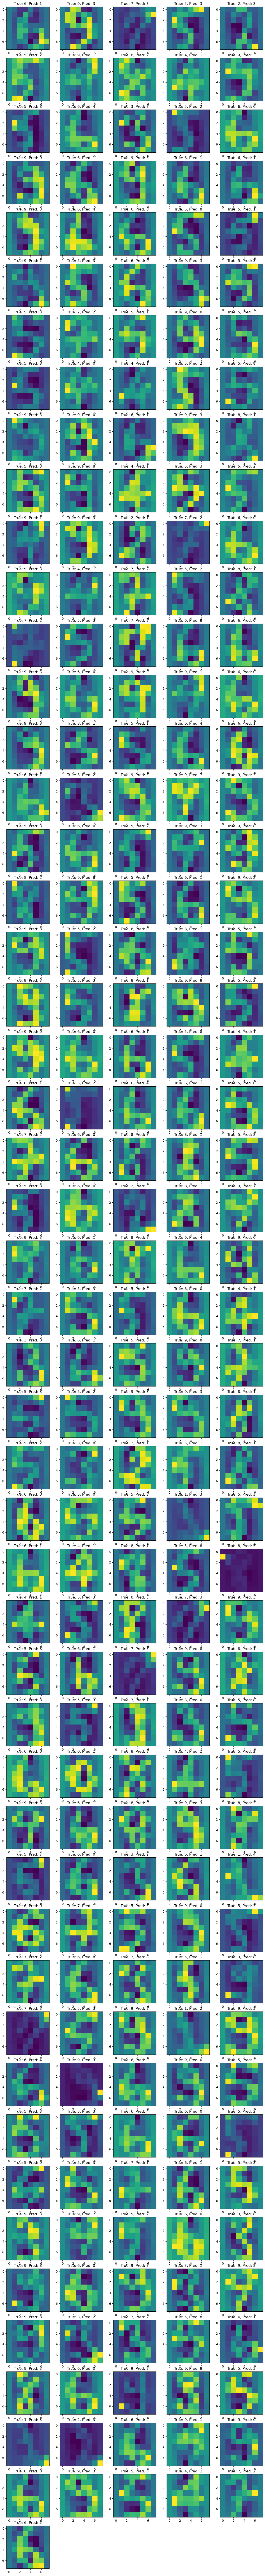

In [14]:
def visualize_all_misclassified_digits(X, y, network):
    predictions = predict(X, network)
    misclassified_indices = np.where(predictions != y)[0]

    num_rows = len(misclassified_indices) // 5 + 1
    num_cols = 5

    plt.figure(figsize=(15, 3 * num_rows))
    for i, index in enumerate(misclassified_indices):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(X[index].reshape(8, 8))
        plt.title(f"True: {y[index]}, Pred: {predictions[index]}")
    plt.show()

# Example usage - first, train the network with a specific learning rate
network = initialize_network()
trained_network, loss_values = train_network(X_train, y_train, network, activation_name='relu', lr=0.001, epochs=1000)

# Now visualize all misclassified digits
visualize_all_misclassified_digits(X_test, y_test, trained_network)


Learning Rate: 0.001
Training Accuracy: 63.01%
Test Accuracy: 60.19%
-----------------------------------
Learning Rate: 0.01
Training Accuracy: 88.70%
Test Accuracy: 87.78%
-----------------------------------
Learning Rate: 0.1
Training Accuracy: 34.21%
Test Accuracy: 31.11%
-----------------------------------


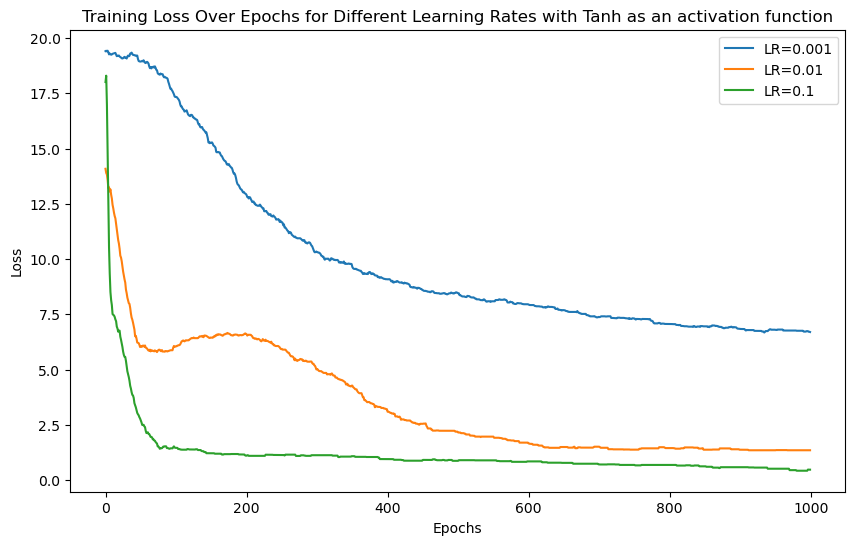

In [15]:

learning_rates = [0.001, 0.01, 0.1]
plt.figure(figsize=(10, 6))

for lr in learning_rates:
    network = initialize_network()
    trained_network, loss_values = train_network(X_train, y_train, network, activation_name='tanh', lr=lr, epochs=1000)

    plt.plot(loss_values, label=f'LR={lr}')

    train_acc = accuracy(X_train, y_train, trained_network)
    test_acc = accuracy(X_test, y_test, trained_network)
    print(f"Learning Rate: {lr}")
    print(f"Training Accuracy: {train_acc * 100:.2f}%")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print("-----------------------------------")


plt.title('Training Loss Over Epochs for Different Learning Rates with Tanh as an activation function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


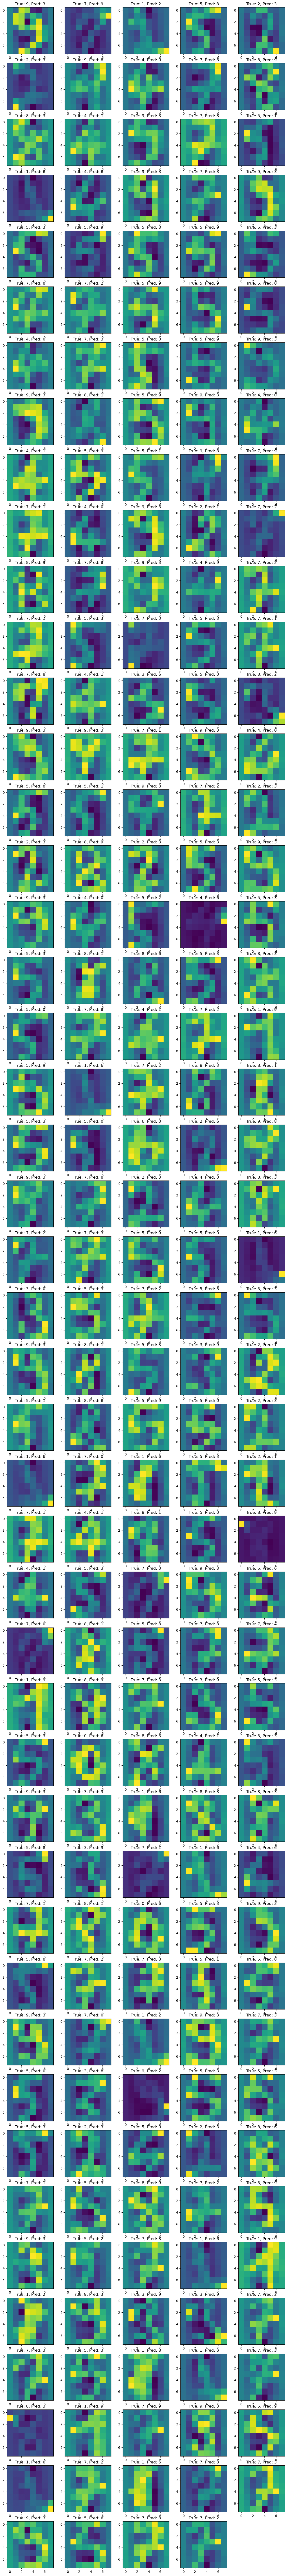

In [16]:
def visualize_all_misclassified_digits(X, y, network):
    predictions = predict(X, network)
    misclassified_indices = np.where(predictions != y)[0]

    num_rows = len(misclassified_indices) // 5 + 1
    num_cols = 5

    plt.figure(figsize=(15, 3 * num_rows))
    for i, index in enumerate(misclassified_indices):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(X[index].reshape(8, 8))
        plt.title(f"True: {y[index]}, Pred: {predictions[index]}")
    plt.show()

# Example usage - first, train the network with a specific learning rate
network = initialize_network()
trained_network, loss_values = train_network(X_train, y_train, network, activation_name='tanh', lr=0.001, epochs=1000)

# Now visualize all misclassified digits
visualize_all_misclassified_digits(X_test, y_test, trained_network)


Learning Rate: 0.001
Training Accuracy: 9.94%
Test Accuracy: 9.81%
-----------------------------------
Learning Rate: 0.01
Training Accuracy: 9.94%
Test Accuracy: 9.81%
-----------------------------------
Learning Rate: 0.1
Training Accuracy: 26.17%
Test Accuracy: 28.70%
-----------------------------------


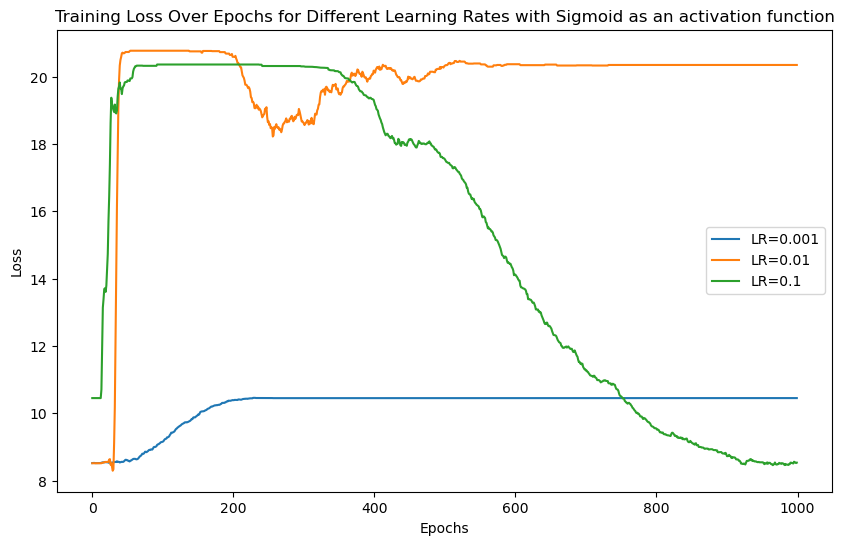

In [17]:

learning_rates = [0.001, 0.01, 0.1]

plt.figure(figsize=(10, 6))


for lr in learning_rates:
    network = initialize_network()
    trained_network, loss_values = train_network(X_train, y_train, network, activation_name='sigmoid', lr=lr, epochs=1000)

    plt.plot(loss_values, label=f'LR={lr}')

    train_acc = accuracy(X_train, y_train, trained_network)
    test_acc = accuracy(X_test, y_test, trained_network)
    print(f"Learning Rate: {lr}")
    print(f"Training Accuracy: {train_acc * 100:.2f}%")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print("-----------------------------------")

plt.title('Training Loss Over Epochs for Different Learning Rates with Sigmoid as an activation function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


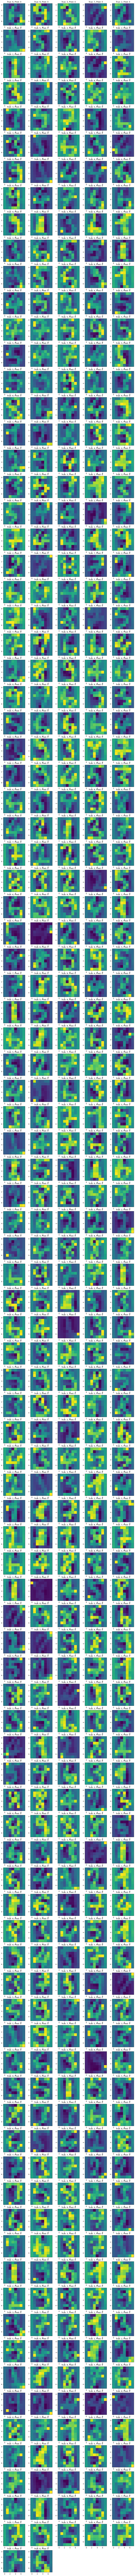

In [18]:
def visualize_all_misclassified_digits(X, y, network):
    predictions = predict(X, network)
    misclassified_indices = np.where(predictions != y)[0]

    num_rows = len(misclassified_indices) // 5 + 1
    num_cols = 5

    plt.figure(figsize=(15, 3 * num_rows))
    for i, index in enumerate(misclassified_indices):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(X[index].reshape(8, 8))
        plt.title(f"True: {y[index]}, Pred: {predictions[index]}")
    plt.show()

# Example usage - first, train the network with a specific learning rate
network = initialize_network()
trained_network, loss_values = train_network(X_train, y_train, network, activation_name='sigmoid', lr=0.001, epochs=1000)

# Now visualize all misclassified digits
visualize_all_misclassified_digits(X_test, y_test, trained_network)
